# Análise de Séries Temporais
Problema de Negócio: 
Usando dados históricos das vendas ao longo de 2023 seria possível prever o total de vendas em Janeiro/2024?

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [2]:
## Carregando os dados

In [3]:
# Carrega o dataset
df = pd.read_csv('dataset.csv')

In [4]:
df.shape

(365, 2)

In [5]:
df.columns

Index(['Data', 'Total_Vendas'], dtype='object')

In [6]:
df.head()

,Data,Total_Vendas
0,2023-01-01,53.483571
1,2023-01-02,57.176993
2,2023-01-03,63.087722
3,2023-01-04,62.103987
4,2023-01-05,44.690396


In [9]:
df.tail()

,Data,Total_Vendas
360,2023-12-27,74.935570
361,2023-12-28,71.374857
362,2023-12-29,57.806920
363,2023-12-30,62.340244
364,2023-12-31,71.650720


Em análise de séries temporais a ordem do tempo importa (por exemplo, coluna 'Data' deve estar em ordem cronológica)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Data          365 non-null    object 
 1   Total_Vendas  365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [8]:
df.describe()

,Total_Vendas
count,365.000000
mean,59.152472
std,10.056436
min,33.265284
25%,51.496725
50%,59.165362
75%,66.610772
max,84.430251


# Pré-processamento dos dados

In [11]:
# Valor mínimo da coluna data
df['Data'].min()

'2023-01-01'

In [12]:
# Valor máximo da coluna data
df['Data'].max()

'2023-12-31'

In [13]:
# Converte a coluna de data no tipo datetime
df['Data'] = pd.to_datetime(df['Data'])

In [14]:
df.head()

,Data,Total_Vendas
0,2023-01-01,53.483571
1,2023-01-02,57.176993
2,2023-01-03,63.087722
3,2023-01-04,62.103987
4,2023-01-05,44.690396


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Data          365 non-null    datetime64[ns]
 1   Total_Vendas  365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [16]:
# Converte o df em série temmporal com a data como índice
serie_temporal = df.set_index('Data')['Total_Vendas']

In [17]:
type(serie_temporal)

pandas.core.series.Series

In [18]:
serie_temporal

Data
2023-01-01    53.483571
2023-01-02    57.176993
2023-01-03    63.087722
2023-01-04    62.103987
2023-01-05    44.690396
                ...    
2023-12-27    74.935570
2023-12-28    71.374857
2023-12-29    57.806920
2023-12-30    62.340244
2023-12-31    71.650720
Name: Total_Vendas, Length: 365, dtype: float64

In [19]:
serie_temporal = serie_temporal.asfreq('D')

In [20]:
serie_temporal

Data
2023-01-01    53.483571
2023-01-02    57.176993
2023-01-03    63.087722
2023-01-04    62.103987
2023-01-05    44.690396
                ...    
2023-12-27    74.935570
2023-12-28    71.374857
2023-12-29    57.806920
2023-12-30    62.340244
2023-12-31    71.650720
Freq: D, Name: Total_Vendas, Length: 365, dtype: float64

## Análise Exploratória

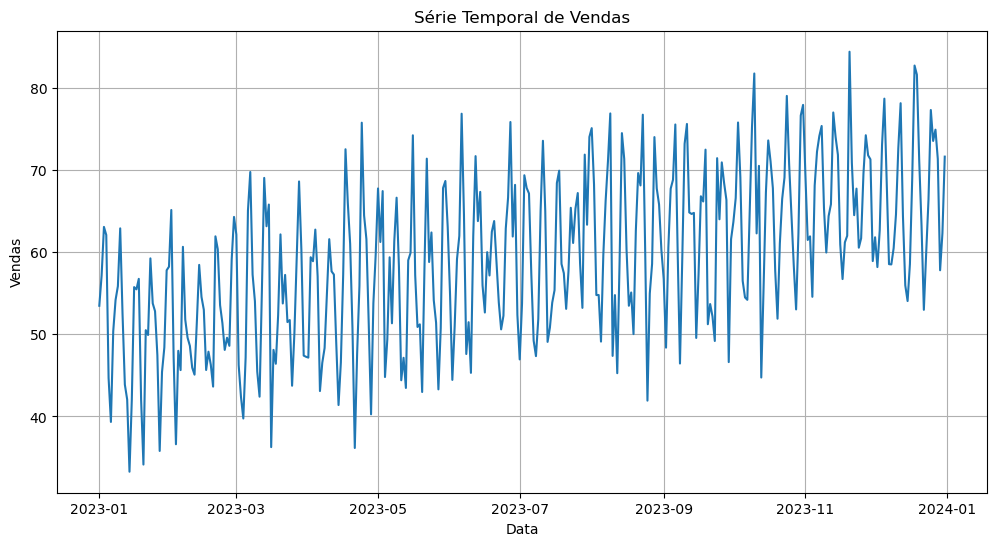

In [21]:
# Cria o gráfico da série temporal (sem formatação)
plt.figure(figsize = (12,6))
plt.plot(serie_temporal)
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Série Temporal de Vendas')
plt.grid(True)
plt.show()

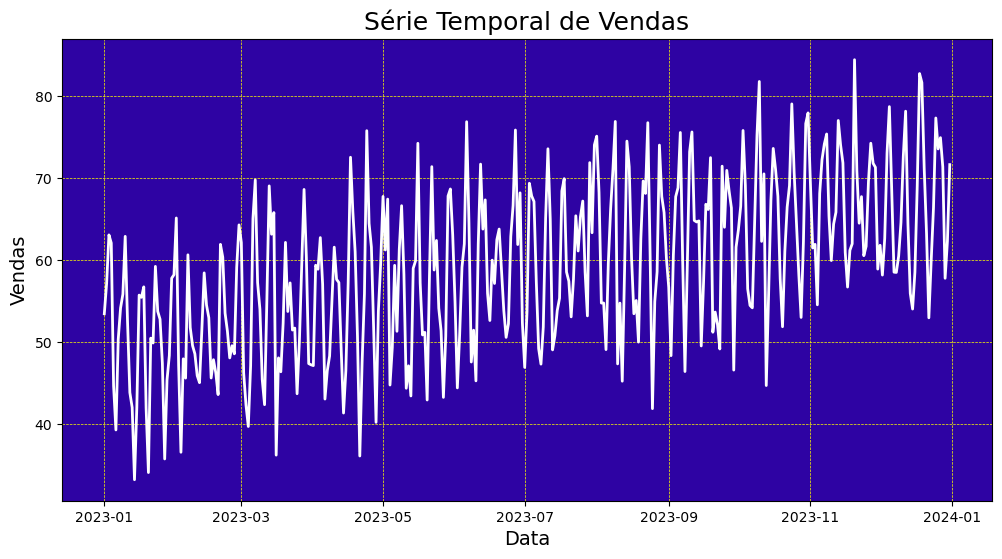

In [22]:
# Cria o gráfico da série temporal (com formatação)

# Cria o gráfico da série temporal com layout de contraste
plt.figure(figsize=(12,6))
plt.plot(serie_temporal, color = 'white', linewidth = 2)

# Configurar cores e estilo do gráfico
plt.gca().set_facecolor('#2e03a3')
plt.grid(color = 'yellow', linestyle = '--', linewidth = 0.5)

# Configurar rótulos dos eixos, título e legenda
plt.xlabel('Data', color = 'black', fontsize = 14)
plt.ylabel('Vendas', color = 'black', fontsize = 14)
plt.title('Série Temporal de Vendas', color = 'black', fontsize=18)

# Configurar as cores dos eixos e dos ticks (marcadores)
plt.tick_params(axis = 'x', color = 'black')
plt.tick_params(axis = 'y', color = 'black')

plt.show()

## Suaviação Exponencial

A suavização exponencial é uma técnica de análise e previsão de séries temporais que aplica médias ponderadas aos dados históricos, onde os pesos diminuem exponencialmente à medida que os dados ficam mais antigos. A suavização exponencial é útil para lidar com tendências e sazonalidades nos dados, e para reduzir o ruído.

### Suposições da Suavização Exponencial

https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html

No Statsmodels, a classe SimpleExpSmoothing é uma implementação da técnica de suavização exponencial simples, que é uma versão mais básica da suavização exponencial que não lida explicitamente com tendências e sazonalidades.

O modelo SimpleExpSmoothing do Statsmodels, também conhecido como suavização exponencial simples ou média móvel exponencialmente ponderada, é uma técnica de suavização de séries temporais que atribui pesos decrescentes exponencialmente aos pontos de dados passados. Ele é usado principalmente para suavizar séries temporais e fazer previsões de curto prazo. As principais suposições do modelo SimpleExpSmoothing são as seguintes:

- A série temporal é composta por um componente de nível (média) e um componente de erro aleatório (ruído). Não há componentes de tendência ou sazonalidade na série.


- O componente de nível é uma média ponderada dos valores passados, com pesos que diminuem exponencialmente à medida que os dados ficam mais distantes no passado.


- O componente de erro aleatório é normalmente distribuído com média zero e variância constante. Além disso, os erros são independentes e identicamente distribuídos.


- O parâmetro de suavização (alfa) é uma constante entre 0 e 1, que determina a taxa de decaimento dos pesos. Valores próximos a 1 dão maior peso aos dados mais recentes, enquanto valores próximos a 0 dão mais peso aos dados mais antigos.

O modelo SimpleExpSmoothing é uma técnica de suavização bastante simples que tem suas limitações. Ele é mais adequado para séries temporais que não apresentam tendências ou sazonalidades claras e para fazer previsões de curto prazo. Para séries temporais com componentes de tendência e/ou sazonalidade, modelos mais avançados como o ExponentialSmoothing de Holt-Winters ou modelos SARIMA podem ser mais apropriados.

In [24]:
# Cria o modelo
modelo = SimpleExpSmoothing(serie_temporal)

A linha acima cria uma instância da classe SimpleExpSmoothing, utilizando a coluna 'Vendas' da série serie_temporal como entrada.

In [25]:
# Treinamento (ajuste) do modelo
modelo_ajustado = modelo.fit(smoothing_level = 0.2)

Esta linha acima faz uma chamada ao método fit() para ajustar o modelo de suavização exponencial aos dados. O argumento smoothing_level=0.2 define o parâmetro de suavização (alfa) como 0.2. O parâmetro de suavização controla a rapidez com que os pesos decrescem ao longo do tempo; um valor maior atribui mais peso aos dados mais recentes, enquanto um valor menor atribui mais peso aos dados mais antigos. O valor de alfa deve estar entre 0 e 1.

In [26]:
# Extrai os valores previstos pelo modelo
suavizacao_exponencial = modelo_ajustado.fittedvalues

Esta linha acima extrai os valores ajustados do modelo de suavização exponencial. Os valores ajustados são as estimativas da série temporal suavizada, que são calculadas aplicando os pesos exponenciais aos dados históricos. Esses valores ajustados podem ser usados para analisar a série temporal suavizada, identificar tendências e comparar com outras técnicas de suavização ou previsão.

O resultado final é uma nova série temporal chamada suavizacao_exponencial, que representa a versão suavizada da série original de vendas, com menos ruído e flutuações de curto prazo.

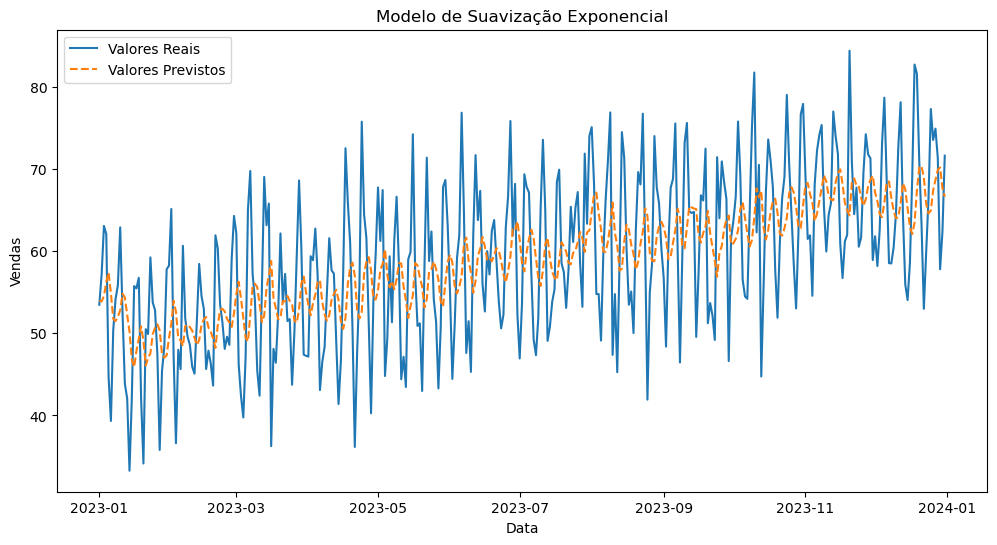

In [27]:
# Plot
plt.figure(figsize = (12, 6))
plt.plot(serie_temporal, label = 'Valores Reais')
plt.plot(suavizacao_exponencial, label = 'Valores Previstos', linestyle = '--')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Modelo de Suavização Exponencial')
plt.legend()
plt.show()

## Deploy e previsão com o modelo treinado

In [37]:
# Fazer previsões
num_previsoes = 1
previsoes = modelo_ajustado.forecast(steps = num_previsoes)

In [36]:
print('Previsão do Total de Vendas para Janeiro/2024:', round(previsoes[0],4))

Previsão do Total de Vendas para Janeiro/2024: 67.6499
